# The data

Join us on an intriguing exploration of a vast agricultural dataset. Uncover the intricate connections between geographic, weather, soil,and farm management features, all leading to a prediction of yield. Our mission? To decode these relationships and empower farmers with actionable insights for improved productivity and informed decision-making.

# Data dictionary
### 1. Geographic features

**Field_ID**: A unique identifier for each field (BigInt).

**Elevation**: The elevation of the field above sea level in metres (Float).

**Latitude**: Geographical latitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

**Longitude**: Geographical longitude of the field in degrees (Float). (DUMMY VARIABLE- the simulation might have created a relationship)

**Location**: Province the field is in (Text).

**Slope**: The slope of the land in the field (Float).


### 2. Weather features

**Rainfall**: Amount of rainfall in the area in mm (Float).

**Min_temperature_C**: Average minimum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

**Max_temperature_C**: Average maximum temperature recorded in Celsius (Float).(DUMMY VARIABLE)

**Ave_temps**: Average temperature in Celcius (Float).


### 3. Soil and crop features

**Soil_fertility**: A measure of soil fertility where 0 is infertile soil, and 1 is very fertile soil (Float).

**Soil_type**: Type of soil present in the field (Text).

**pH**: pH level of the soil, which is a measure of how acidic/basic the soil is (Float).


### 4. Farm management features

**Field_ID**: Corresponding field identifier (BigInt).

**Pollution_level**: Level of pollution in the area where 0 is unpolluted and 1 is very polluted (Float).

**Plot_size**: Size of the plot in the field (Ha) (Float). (DUMMY VARIABLE)

**Chosen_crop**: Type of crop chosen for cultivation (Text).

**Annual_yield**: Annual yield from the field (Float). This is the total output of the field. The field size and type of crop will affect the Annual Yield (DUMMY VARIABLE - Removed)


### 5. Target variable

**Standard_yield**: Standardised yield expected from the field, normalised per crop (Float). This is independent of field size, or crop type. Multiplying this number by the field size, and average crop yield will give the Annual_Yield.

**Important**: Ensure that data_ingestion.py file and the field_data_processor.py files are stored in the same folder as your notebook, otherwise the data import will fail.

In [1]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.graphics.correlation as sgc
from statsmodels.graphics.gofplots import qqplot
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import OLSInfluence
import seaborn as sns

In [2]:
# Read the database, and clean the data using the processing modules we built.

import re
import numpy as np
import pandas as pd
from field_data_processor import FieldDataProcessor
# from weather_data_processor import WeatherDataProcessor
import logging 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

config_params = {
    "sql_query": """
            SELECT *
            FROM geographic_features
            LEFT JOIN weather_features USING (Field_ID)
            LEFT JOIN soil_and_crop_features USING (Field_ID)
            LEFT JOIN farm_management_features USING (Field_ID)
            """,
    "db_path": 'sqlite:///Maji_Ndogo_farm_survey_small.db',
    "columns_to_rename": {'Annual_yield': 'Crop_type', 'Crop_type': 'Annual_yield'},
    "values_to_rename": {'cassaval': 'cassava', 'wheatn': 'wheat', 'teaa': 'tea'},
    "weather_csv_path": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_station_data.csv",
    "weather_mapping_csv": "https://raw.githubusercontent.com/Explore-AI/Public-Data/master/Maji_Ndogo/Weather_data_field_mapping.csv",
    "regex_patterns" : {
            'Rainfall': r'(\d+(\.\d+)?)\s?mm',
            'Temperature': r'(\d+(\.\d+)?)\s?C',
            'Pollution_level': r'=\s*(-?\d+(\.\d+)?)|Pollution at \s*(-?\d+(\.\d+)?)'
            },
}
# Ignoring the field data for now.
field_processor = FieldDataProcessor(config_params)
field_processor.process()
field_df = field_processor.df

# We're not going to use the weather data this time, so we'll ignore it.
# weather_processor = WeatherDataProcessor(config_params)
# weather_processor.process()
# weather_df = weather_processor.weather_df

dataset = field_df.drop("Weather_station", axis=1)

2024-05-11 09:36:56,344 - data_ingestion - INFO - Database engine created successfully.
2024-05-11 09:36:56,482 - data_ingestion - INFO - Query executed successfully.
2024-05-11 09:36:56,482 - field_data_processor.FieldDataProcessor - INFO - Sucessfully loaded data.
2024-05-11 09:36:56,491 - field_data_processor.FieldDataProcessor - INFO - Swapped columns: Annual_yield with Crop_type
2024-05-11 09:36:59,182 - data_ingestion - INFO - CSV file read successfully from the web.


Before diving into our analysis, it's crucial to ensure the integrity of our dataset and that the data is still as we expect it to be.

In [3]:
# Validate the data
#!pip install pytest

dataset.to_csv('sampled_field_df.csv', index=False)

!pytest validate_data.py -v

import os# Define the file paths
field_csv_path = 'sampled_field_df.csv'

# Delete sampled_field_df.csv if it exists
if os.path.exists(field_csv_path):
    os.remove(field_csv_path)
    print(f"Deleted {field_csv_path}")
else:
    print(f"{field_csv_path} does not exist.")

============================= test session starts =============================
platform win32 -- Python 3.11.5, pytest-7.4.0, pluggy-1.0.0 -- C:\Users\Mukaidziwa M\anaconda3\python.exe
cachedir: .pytest_cache
rootdir: C:\Users\Mukaidziwa M\Desktop\ALX-DS\Regression\Regression Exam
plugins: anyio-3.5.0
collecting ... collected 4 items

validate_data.py::test_read_field_dataframe_shape PASSED                 [ 25%]
validate_data.py::test_field_dataframe_columns PASSED                    [ 50%]
validate_data.py::test_field_dataframe_non_negative_elevation PASSED     [ 75%]
validate_data.py::test_crop_types_are_valid PASSED                       [100%]

============================== 4 passed in 2.88s ==============================
Deleted sampled_field_df.csv


# Challenge 1: 

Understanding our variables and variable selection
In this section, we will analyse the predictor variables in our dataset and how they relate to the target variable.

## Task 1
How many predictors do we originally have in our dataset, and which of these are categorical in nature?

In [5]:
# Your code here

# Drop 'Field_ID' columns
dataset = dataset.drop(['Field_ID'], axis=1)

# Get the number of predictors (columns) in the dataset
num_predictors = len(dataset.columns) -1

# Identify categorical predictors
categorical_predictors = dataset.select_dtypes(include=['object']).columns.tolist()

print("Number of predictors:", num_predictors)
print("Categorical predictors:", categorical_predictors)

Number of predictors: 16
Categorical predictors: ['Location', 'Soil_type', 'Crop_type']


## Task 2
The categorical features in our dataset need to be converted into a format suitable for modeling. After applying dummy variable encoding to these categorical features, how many independent variables do we now have?

In [6]:
# Your code here

# Perform dummy variable encoding
dataset_encoded = pd.get_dummies(dataset, drop_first=True)

# Get the number of independent variables
num_independent_variables = len(dataset_encoded.columns) -1

print("Number of independent variables after dummy variable encoding:", num_independent_variables)


Number of independent variables after dummy variable encoding: 29


## Task 3
From our encoded dataset, which variable has the third highest absolute correlation with the Standard_yield, excluding the variable itself?

In [7]:
# Your code here
# Convert boolean columns to integer type
bool_columns = dataset_encoded.select_dtypes(include=[bool]).columns
dataset_encoded[bool_columns] = dataset_encoded[bool_columns].astype(int)

In [8]:
# Your code here
# Calculate the correlation matrix
correlation_matrix = dataset_encoded.corr()

# Exclude 'Standard_yield' and calculate absolute correlations
abs_correlations = correlation_matrix['Standard_yield'].drop('Standard_yield').abs()

# Sort absolute correlations in descending order
sorted_correlations = abs_correlations.sort_values(ascending=False)

# Select the variable with the third highest absolute correlation
third_highest_correlation_variable = sorted_correlations.index[2]

print("Variable with the third highest absolute correlation with Standard_yield (excluding itself):", third_highest_correlation_variable)


Variable with the third highest absolute correlation with Standard_yield (excluding itself): Pollution_level


## Task 4
In order to fit an ordinary least squares regression model to our encoded data we would need to make sure that all our variables are numeric. Through dummy variable encoding, we converted our categorical variables to multiple int/boolean variables (depending on the environment you are working on). The sm.OLS() method itself does not inherently handle boolean data types implicitly.

In most cases, when fitting a model with sm.OLS(), it's essential to ensure that all features are numeric. If boolean columns are present, they should be explicitly converted to numeric types before fitting the model.

In [10]:
# Your code here

dataset_encoded.info()

print('The boolean columns have been replaced with binary integer representations, with True converted to 1 and False converted to 0.')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5654 entries, 0 to 5653
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Elevation                5654 non-null   float64
 1   Latitude                 5654 non-null   float64
 2   Longitude                5654 non-null   float64
 3   Slope                    5654 non-null   float64
 4   Rainfall                 5654 non-null   float64
 5   Min_temperature_C        5654 non-null   float64
 6   Max_temperature_C        5654 non-null   float64
 7   Ave_temps                5654 non-null   float64
 8   Soil_fertility           5654 non-null   float64
 9   pH                       5654 non-null   float64
 10  Pollution_level          5654 non-null   float64
 11  Plot_size                5654 non-null   float64
 12  Annual_yield             5654 non-null   float64
 13  Standard_yield           5654 non-null   float64
 14  Location_Rural_Amanzi   

## Task 5
Suppose we wish to determine which of the predictors in our dataset are statistically significant. We will follow the following steps:

Fit a statsmodels regression model to predict Standard_yield using our encoded dataset.
Extract p-values for each predictor from the fitted model to find the ones that are significant based on a given threshold.

Which variables do we find to be statistically significant for predicting Standard_yield, based on a p-value threshold of 0.05 (p-value < 0.05)?

In [11]:
# Your code here

# Assuming you have your encoded data in a pandas DataFrame called 'dataset_encoded'
# Standard_yield is the target variable, and other columns are your predictors
import statsmodels.formula.api as sm


# 1. Fit the model (replace 'predictor1' etc. with your actual column names)
formula = 'Standard_yield ~ Elevation + Latitude + Longitude + Slope + Rainfall + Min_temperature_C + Max_temperature_C + Ave_temps + Soil_fertility + pH + Pollution_level + Plot_size + Annual_yield + Location_Rural_Amanzi + Location_Rural_Hawassa + Location_Rural_Kilimani + Location_Rural_Sokoto + Soil_type_Peaty + Soil_type_Rocky + Soil_type_Sandy + Soil_type_Silt + Soil_type_Volcanic + Crop_type_cassava + Crop_type_coffee + Crop_type_maize + Crop_type_potato + Crop_type_rice + Crop_type_tea + Crop_type_wheat'

#formula = 'Standard_yield ~ ' + ' + '.join(dataset_encoded.columns)
model = smf.ols(formula=formula, data=dataset_encoded).fit()


# 2. Print the model summary
print(model.summary())

# 3. Identify significant variables (manual approach)
pvalues = model.pvalues  # Get p-values for each predictor

# Set your significance threshold
significance_threshold = 0.05

significant_variables = []
for name, pval in zip(model.params.index, pvalues):
  if pval < significance_threshold:
    significant_variables.append(name)

print("Significant variables (p-value <", significance_threshold, "):")
print(significant_variables)

print("Answer: pH")

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Sat, 11 May 2024   Prob (F-statistic):               0.00
Time:                        09:53:14   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+04
Df Residuals:                    5625   BIC:                        -1.647e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [12]:
# Your code here
import statsmodels.api as sms

X = dataset_encoded.drop(columns="Standard_yield")
y = dataset_encoded["Standard_yield"]
# Fit a regression model
model = sms.OLS(y, X).fit()

# Extract p-values for each predictor
p_values = model.pvalues

# Filter significant predictors based on the p-value threshold (0.05)
significant_predictors = p_values[p_values < 0.05]

# Print the statistically significant predictors
print("Statistically significant predictors:")
significant_predictors.sort_values(ascending=False)

Statistically significant predictors:


Max_temperature_C           4.382364e-02
Ave_temps                   4.267652e-02
Min_temperature_C           4.069080e-02
Longitude                   2.639446e-02
Elevation                   2.771178e-03
Location_Rural_Kilimani     1.301622e-03
Latitude                    9.646949e-04
Location_Rural_Sokoto       3.181955e-14
Crop_type_cassava           4.229825e-23
Crop_type_maize             3.850531e-32
Soil_type_Volcanic          2.623309e-36
pH                          3.459676e-47
Crop_type_wheat             9.041916e-51
Soil_type_Peaty             3.982477e-61
Soil_type_Rocky             3.150905e-84
Crop_type_rice             6.448104e-118
Soil_type_Sandy            8.240635e-122
Soil_type_Silt             3.031643e-136
Crop_type_potato           4.149533e-142
Crop_type_tea              1.592562e-196
Pollution_level            8.999182e-245
Plot_size                   0.000000e+00
Annual_yield                0.000000e+00
dtype: float64

# Challenge 2: 

Generating a multiple linear regression model

After encoding our variables and performing preliminary analysis, let's continue our efforts to identify the variables that will enable us to construct the most accurate multiple linear regression model possible with the data that we have.

## Task 6
Create a correlation matrix using all the columns in our encoded dataset and display it as a heatmap.

Which independent variables have a strong correlation with one another.

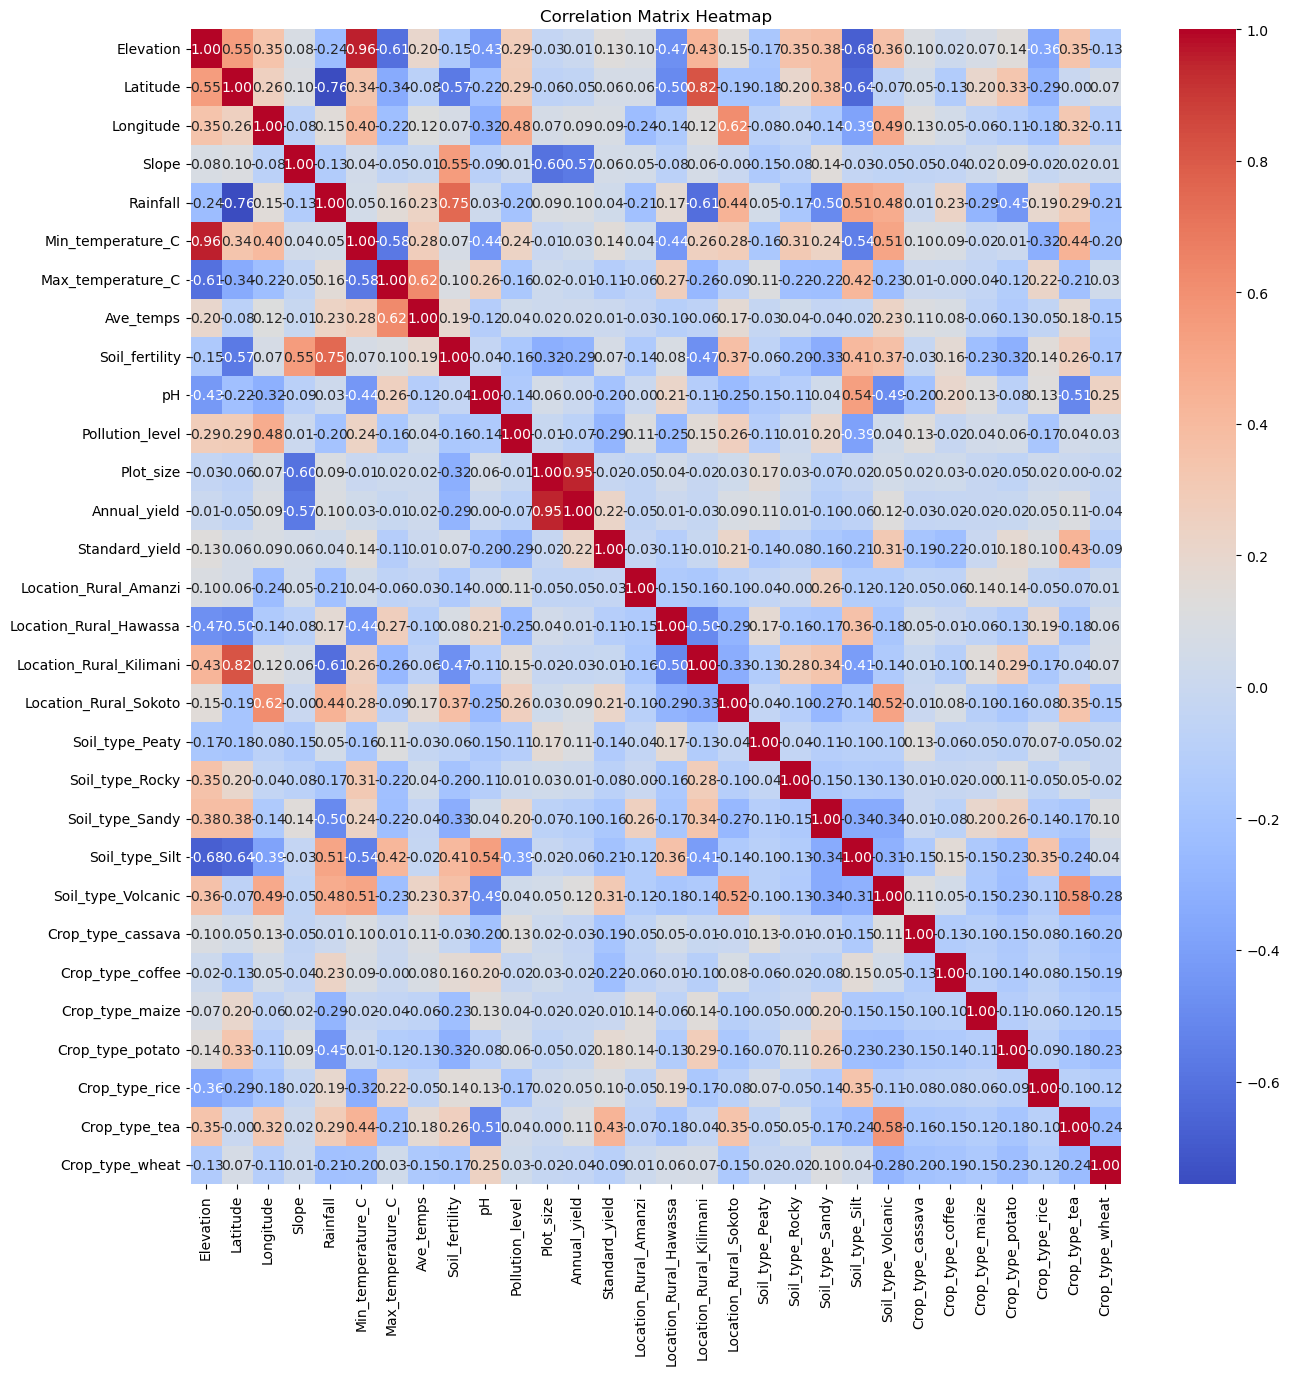

Answer: Min_temperature_C and Elevation


In [13]:
# Create the correlation_matrix


# Calculate the correlation matrix
correlation_matrix = dataset_encoded.corr()

# Plot the heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()
print('Answer: Min_temperature_C and Elevation')

## Task 7
Now that we have analysed our variables, let's fit an ordinary least squares regression model using statsmodels.formula.api and then print the model summary. Construct the model using all the independent variables in our encoded dataset (excuding Field_ID).

Which  accurately describes the interpretation of the F-statistic in the context of our regression model?

In [14]:
# # Your code here
import statsmodels.formula.api as smf

independent_cols = dataset_encoded.drop(columns=["Standard_yield"]).columns

dependent_var = 'Standard_yield'


# # Generating the regression string
formula_str = dependent_var+ ' ~ ' + ' + '.join(independent_cols)
formula_str
# # Construct and fit the model
model = smf.ols(formula_str, data=dataset_encoded)
model = model.fit()

# #Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     623.8
Date:                Sat, 11 May 2024   Prob (F-statistic):               0.00
Time:                        09:59:03   Log-Likelihood:                 8358.2
No. Observations:                5654   AIC:                        -1.666e+04
Df Residuals:                    5625   BIC:                        -1.647e+04
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [15]:
# Your code here

import statsmodels.formula.api as smf

# Construct the formula for regression
# Assuming 'Standard_yield' is the dependent variable and 'dataset' contains the encoded dataset
formula = 'Standard_yield ~ ' + ' + '.join(dataset_encoded.columns)
 
# Fit the OLS regression model
model = smf.ols(formula=formula, data=dataset_encoded).fit()

# Print the model summary
print(model.summary())

print('Answer: The F-statistic tests the overall significance of the regression model. A high F-statistic value with a corresponding low p-value indicates that the regression model is statistically significant, meaning that at least one of the independent variables has a significant effect on the dependent variable.')

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.807e+29
Date:                Sat, 11 May 2024   Prob (F-statistic):               0.00
Time:                        09:59:33   Log-Likelihood:             1.8440e+05
No. Observations:                5654   AIC:                        -3.687e+05
Df Residuals:                    5624   BIC:                        -3.685e+05
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                4

## Task 8

This summary gives us an indication of possible multicollinearity present within our predictor variables. The presence of any correlation among predictors is detrimental to model quality because it tends to increase the standard error of the coefficients and it becomes difficult to estimate the effect of any one predictor variable on the response variable.

To avoid this, let's reduce the number of independent variables included in our model. Fit the model using the following variables:

- Pollution_level
- Crop_type_coffee
- Crop_type_tea
- Location_Rural_Sokoto
- Annual_yield
- Soil_type_Silt
- Soil_type_Volcanic

After reducing the number of dependent variables accordingly, how did the model change?

In [16]:
# Your code here

import statsmodels.formula.api as smf

# Columns to keep
columns_to_keep = ['Pollution_level', 'Crop_type_coffee', 'Crop_type_tea',
                   'Location_Rural_Sokoto', 'Annual_yield', 'Soil_type_Silt',
                   'Soil_type_Volcanic']


independent_cols = dataset_encoded[columns_to_keep]

dependent_var = 'Standard_yield'


# # Generating the regression string
formula_str = dependent_var+ ' ~ ' + ' + '.join(independent_cols)
formula_str
# # Construct and fit the model
model = smf.ols(formula_str, data=dataset_encoded)
model = model.fit()

# #Print the model summary
print(model.summary())

print('Answer: The model improved.')

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.406
Method:                 Least Squares   F-statistic:                     552.1
Date:                Sat, 11 May 2024   Prob (F-statistic):               0.00
Time:                        10:29:22   Log-Likelihood:                 5839.8
No. Observations:                5654   AIC:                        -1.166e+04
Df Residuals:                    5646   BIC:                        -1.161e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.56

In [17]:
# Your code here

import statsmodels.formula.api as smf

# Columns to keep
columns_to_keep = ['Pollution_level', 'Crop_type_coffee', 'Crop_type_tea',
                   'Location_Rural_Sokoto', 'Annual_yield', 'Soil_type_Silt',
                   'Soil_type_Volcanic', 'Standard_yield']


# Drop columns not in columns_to_keep
dataset_selected = dataset_encoded[columns_to_keep]

# Construct the formula for regression
# Assuming 'Standard_yield' is the dependent variable and 'df_selected' contains the selected columns
formula = 'Standard_yield ~ ' + ' + '.join(dataset_selected.columns)

# Fit the OLS regression model
model = smf.ols(formula=formula, data=dataset_selected).fit()

# Print the model summary
print(model.summary())

print('Answer: The model improved.')

                            OLS Regression Results                            
Dep. Variable:         Standard_yield   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.755e+31
Date:                Sat, 11 May 2024   Prob (F-statistic):               0.00
Time:                        10:32:52   Log-Likelihood:             1.8921e+05
No. Observations:                5654   AIC:                        -3.784e+05
Df Residuals:                    5645   BIC:                        -3.783e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              9.003e-

## Task 9

Let's evaluate our model's results. Generate a scatter plot of the residuals against the fitted values allowing us to visually inspect whether the residuals have constant variance and are distributed randomly around the zero residual line.

What does the scatter plot tell us?

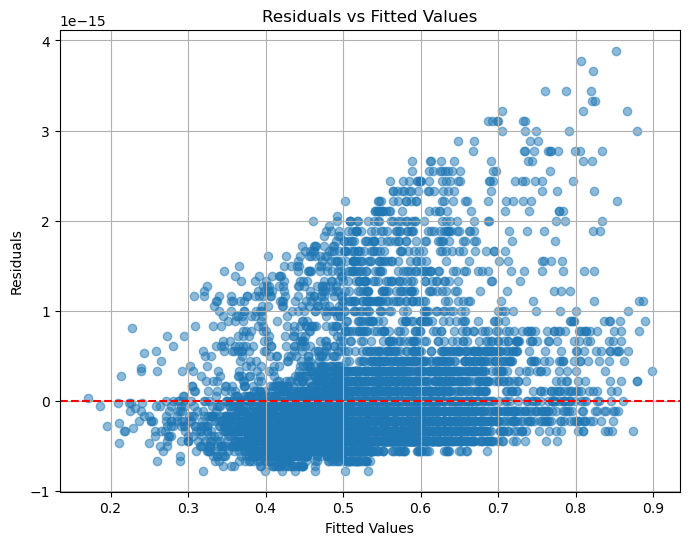

In [18]:
import matplotlib.pyplot as plt

# Get the fitted values
fitted_values = model.fittedvalues

# Calculate residuals
residuals = model.resid

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(fitted_values, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at y=0
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

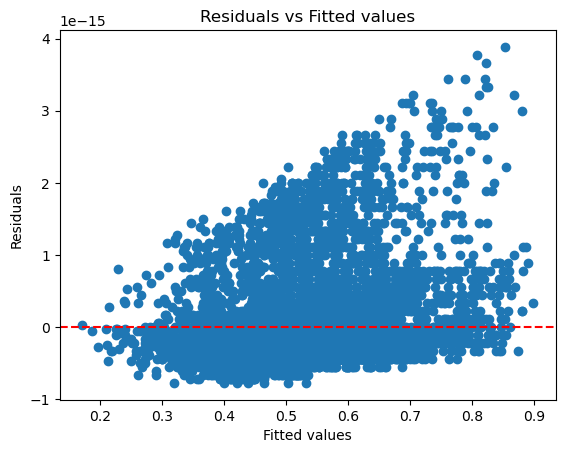

Answer: The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line


In [19]:
#Your code here

import matplotlib.pyplot as plt

# Calculate residuals
residuals = model.resid

# Get predicted values (fitted values)
fitted_values = model.fittedvalues

# Plot residuals against fitted values
plt.scatter(fitted_values, residuals)
plt.axhline(y=0, color='red', linestyle='--')  # Add zero residual line
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted values')
plt.show()

print('Answer: The plot indicates homoscedasticity as residuals have a constant variance and are distributed randomly around the zero residual line')

##Task 10

If a linear regression model indicated heteroscedasticity, this 3 actions could be considered to address this issue?

- Applying transformations to the independent variables to better fit the linear relationship.
- Implementing weighted least squares regression to give less emphasis to observations with higher variance in residuals.
- Removing outliers from the dataset to reduce the impact of extreme values on the variance of residuals.

# Challenge 3: 

Using regularisation to optimise agricultural yield

Continuing with our task, after fitting our model, we decide to go back to the drawing board to explore more ways to implement feature engineering and data pre-processing in order to optimise our model. We suspect that, if we use all the variables available to us, the model might overfit due to the high dimensionality of the data. Regularisation techniques will therefore be critical in building a predictive model that generalises well to new, unseen data.

## Task 11

Our first step in the feature engineering involves creating a new feature, Temperature_Range, and scaling features using StandardScaler. The difference between Min_temperature_C and Max_temperature_C is the temperature range.


In [20]:
from sklearn.preprocessing import StandardScaler

# Insert selected option here

# Create a new feature 'Temperature_Range' Answer
dataset['Temperature_Range'] = dataset['Max_temperature_C'] - dataset['Min_temperature_C']

# Select features for scaling (exclude non-numeric or target variables)
features = ['Elevation', 'Slope', 'Rainfall', 'Ave_temps', 'Temperature_Range', 'Soil_fertility', 'pH', 'Pollution_level']

# Initialise StandardScaler and apply it to the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(dataset[features])

# Show the first 5 rows of the scaled features
print(scaled_features[:5])

[[ 0.85426539  0.31997088 -0.15356676  2.21747303  0.30626766  0.01544079
   0.71256827 -0.61634976]
 [ 0.21055364 -0.03858151  0.49777372  0.15900087 -0.25298298  0.4619994
   0.08816394  0.7886906 ]
 [ 1.08748981 -0.04224188  2.01496684  0.09662293 -1.66755812  1.57839593
  -0.34858051  0.60254524]
 [-0.3620941  -0.4856324  -1.74719984 -0.02813296  0.8984154  -1.77079366
  -0.35345077  0.28374058]
 [ 1.43215211  4.53523034 -0.83392242  1.28180387 -0.58195394  2.24823384
   0.14466333 -0.80437805]]


## Task 12

Consider a scenario where we decide to employ LASSO regression to identify predictive features associated with our dependent variable.

What is the purpose of the LassoCV(cv=5) constructor parameter cv=5?

In [22]:
from sklearn.linear_model import LassoCV

# scaled_features is our matrix of scaled features and dataset['Standard_yield'] is the target variable
lasso = LassoCV(cv=5).fit(scaled_features, dataset['Standard_yield'])

# Find the features with non-zero coefficients
selected_features = [features[i] for i, coef in enumerate(lasso.coef_) if coef != 0]

print('Answer: It indicates that 5-fold cross-validation should be used to select the best regularization parameter.')

Answer: It indicates that 5-fold cross-validation should be used to select the best regularization parameter.


## Task 13

In trying to address multicollinearity in our dataset, we also decide to implement Ridge regression. After understanding that Ridge regression applies an L2 penalty to the coefficients to reduce their magnitude without setting them to zero, we decide to use `RidgeCV` for applying Ridge regression with cross-validation to select the optimal penalty strength. This parameter correctly adjusts the strength of the regularisation applied to the model?

In [23]:
from sklearn.linear_model import RidgeCV

# Insert selected option here
alphas=[0.001, 0.01, 0.1, 1, 10, 100]

# Apply Ridge regression with cross-validation
ridge = RidgeCV(alphas=alphas, cv=5).fit(scaled_features, dataset['Standard_yield'])

## Task 14
Given our dataset includes variables such as Elevation and Slope, and considering the potential interactions between these variables might impact crop yield, we aim to capture both these interactions and possible non-linear relationships. this methods is specifically designed to create a quadratic interaction term without including an intercept in the feature set?

In [24]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial and interaction features
#Insert selected option here
poly = PolynomialFeatures(degree=2, include_bias=False)

poly_features = poly.fit_transform(dataset[['Elevation', 'Slope']])

# Display the shape of the new feature matrix
poly_features.shape

(5654, 5)

## Task 15

After implementing Ridge regression to address multicollinearity and prevent overfitting in our model we need to interpret the coefficients to understand the impact of each feature on the standard yield.

Based on the output of the Ridge regression coefficients in the code block below, this statement is true regarding the impact of each feature on the standard yield?

In [25]:
from sklearn.linear_model import Ridge
import numpy as np

# Assuming `X` is the feature matrix and `y` is the target variable
X = np.array([[0.5, 0.2, 0.1],
              [0.9, 0.3, 0.5],
              [0.3, 0.8, 0.2]])
y = np.array([0.7, 0.6, 0.8])

# Fit Ridge regression model with alpha = 0.1
ridge_model = Ridge(alpha=0.1)
ridge_model.fit(X, y)

# Display the coefficients of the model
ridge_model.coef_

print('Answer: Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.')

Answer: Feature 2 has the highest positive impact, while Feature 3 and Feature 1 have negative impacts.


# Challenge 4: 

Making a prediction using decision trees

After learning that decision trees are easy to implement and are capable of handling both categorical and numerical data while being resilient to outliers, we decide to implement a decision tree on our encoded dataset.

## Task 16

Train a decision tree with the following specifications:

Using our previously encoded dataset, split the data into dependent and independent variables using all the features except for Standard_yield and Field_ID as independent variables.
Split the data into training and testing data.

Use the DecisionTreeRegressor to fit a model using a max_depth' of 2 and a random_state` of 42.

In [26]:
# Your code here

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Independent variables (features)
X = dataset_encoded.drop(['Standard_yield'], axis=1)

# Dependent variable (target)
y = dataset_encoded['Standard_yield']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize DecisionTreeRegressor with max_depth=2 and random_state=42
decision_tree = DecisionTreeRegressor(max_depth=2, random_state=42)

# Fit the model to the training data
decision_tree.fit(X_train, y_train)

# Make a prediction for the given x-values
x_values = [[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004, 16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]]
x_values = pd.DataFrame(x_values, columns=X.columns)

predicted_y = decision_tree.predict(x_values)

# Print the predicted y
print("Predicted y:", predicted_y)

Predicted y: [0.48494414]


## Task 17

Based on the model above, what is the value of our RMSE?

In [28]:
# Your code here
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions on the test set
y_pred = decision_tree.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.08805783663217344


## Task 18

The following statements is correct about our RMSE?

An RMSE of 0.0881 suggests that, on average, the predicted values are off by approximately 0.0881 units.

## Task 19

What is the likely effect of adjusting the max_depth parameter in a Decision Tree mode

Higher max_depth values may lead to increased model complexity and a higher risk of overfitting.

## Task 20 

Let's attempt to enhance our model's performance by setting the `max_depth` hyperparameter to 5.

its true, The decision tree model was improved by fitting it with a `max_depth` parameter of 5.


In [30]:
# Your code here

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor

# Independent variables (features)
X = dataset_encoded.drop(['Standard_yield'], axis=1)

# Dependent variable (target)
y = dataset_encoded['Standard_yield']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize DecisionTreeRegressor with max_depth=2 and random_state=42
decision_tree = DecisionTreeRegressor(max_depth=5, random_state=42)

# Fit the model to the training data
decision_tree.fit(X_train, y_train)

# Make a prediction for the given x-values
x_values = [[864.66138, -8.12890218821531, -8.311822719284072, 16.274624300000003, 1237.7200000000003, -3.4100000000000006, 36.410000000000004, 16.5,0.682, 6.7863323423108195, 0.09379352739936421, 1.4300000000000002, 0.8264890400277934,0.0,0.0,0.0,0.0,0.0,0.0,1.1,0.0,0.0,1.1,0.0, 0.0,0.0,0.0,0.0,0.0]]
predicted_y = decision_tree.predict(x_values)

# Print the predicted y
print("Predicted y:", predicted_y)

# Your code here
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions on the test set
y_pred = decision_tree.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(y_test, y_pred)

# Calculate root mean squared error
rmse = np.sqrt(mse)

print("Root Mean Squared Error (RMSE):", rmse)


Predicted y: [0.49287275]
Root Mean Squared Error (RMSE): 0.06332974532698206


C:\Users\Mukaidziwa M\anaconda3\envs\create_an_environment\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


# Challenge 5: 
    
Ensemble Methods & Bootstrapping

Using our original dataset, our objective is to explore ensemble methods and bootstrapping techniques to enhance the model performance. We'll work with a subset of features from the dataset to predict the Standard_yield.

## Task 21

Consider the following approach to implement a bootstrap aggregation (bagging) for predicting the Standard_yield based on features Elevation, Slope, Soil_fertility, and Pollution_level. Given are the steps and part of the Python code implementing this method. Our task is to identify the correct piece of code that completes the implementation.

The steps for the implementation are as follows:

1. Create an empty list named predictions to store predictions from each bootstrap sample.
2. Generate n_bootstrap_samples bootstrap samples from the original dataset.
3. For each bootstrap sample, fit a linear regression model and predict the Standard_yield on the entire dataset.
4. Store each set of predictions in the predictions list.
5. Average the predictions across all bootstrap samples to obtain the final bagged prediction.
6. Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model.

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample
import numpy as np

# X_train, y_train represent the features and target variable from the training data
X = dataset[['Elevation', 'Slope', 'Soil_fertility', 'Pollution_level']]
y = dataset['Standard_yield']

predictions = []
n_bootstrap_samples = 100

for _ in range(n_bootstrap_samples):
    X_sample, y_sample = resample(X, y)
    model = LinearRegression()
    model.fit(X_sample, y_sample)
    y_pred = model.predict(X)
    predictions.append(y_pred)

# MISSING PART HERE Answer

# Average the predictions across all bootstrap samples to obtain the final bagged prediction
bagged_prediction = np.mean(predictions, axis=0)

# Compute and print the mean squared error (MSE) to evaluate the performance of the bagged model
mse_bagged = mean_squared_error(y, bagged_prediction)

print(f"Mean Squared Error of Bagged Linear Regression Models: {mse_bagged}")

Mean Squared Error of Bagged Linear Regression Models: 0.010840549517171803


## Task 22

The following code snippet that applies a RandomForestRegressor to a dataset, which parameter in the RandomForestRegressor constructor is crucial for implementing the random subspace method by allowing the algorithm to select a random subset of features for each split?

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Initialise and train the random forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X, y)

# Predict using the random forest model
y_pred_rf = rf_model.predict(X)

# Evaluate the model
mse_rf = mean_squared_error(y, y_pred_rf)
print(f"Mean Squared Error of Random Forest Regressor: {mse_rf}")
print('Answer: max_features')

Mean Squared Error of Random Forest Regressor: 0.0011063749097447505
Answer: max_features


## Task 23 

Consider the theoretical setup for a stacking ensemble model designed for a regression task. The first layer of this model includes three different types of regression models: linear regression, ridge regression, and a support vector machine (SVM) with a linear kernel. The second layer, or the final estimator, uses a linear regression model to combine the predictions from the first layer. The goal is to theoretically predict Standard_yield based on features such as Elevation, Slope, Soil_fertility, and Pollution_level, with the intention to evaluate the model's hypothetical performance using the Mean Squared Error (MSE).

In [36]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

# Define base learners
estimators = [
    ('lr', LinearRegression()),
    ('ridge', Ridge()),
    ('svr', SVR(kernel='linear'))
]

# Define the theoretical stacking model
stacking_model = StackingRegressor(estimators=estimators, final_estimator=LinearRegression())

# Note: Assume X, y represent the features and target variable respectively, for a theoretical prediction scenario.

## Task 24

Consider the following Python code snippet that aims to implement a 5-fold cross-validation scheme to estimate the accuracy of a ridge regression model. This model uses bootstrapped samples within each fold to predict Standard_yield and calculates the average Mean Squared Error (MSE) across all folds.

In [37]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
import numpy as np

# Initialise the ridge regression model
ridge_model = Ridge()

# Perform 5-fold cross-validation with bootstrapping
scores = cross_val_score(ridge_model, X, y, scoring='neg_mean_squared_error', cv=5) #add correct option here 

# Convert scores to positive MSE
mse_scores = -scores

# Calculate average MSE
average_mse = np.mean(mse_scores)
print(f"Average Mean Squared Error from Cross-Validation: {average_mse}")

Average Mean Squared Error from Cross-Validation: 0.010875483717316465


## Task 25

Consider the code snippet that extracts and prints the feature importances from a trained random forest regressor model. The model is used to predict Standard_yield based on various features. The code utilises the feature_importances_ attribute of the random forest model to obtain importance scores for each feature.

In [38]:
# Extract feature importances
feature_importances = rf_model.feature_importances_

# Print feature importances
for feature, importance in zip(X.columns, feature_importances):
    print(f"Feature: {feature}, Importance: {importance}")
    
print('Answer: The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the models ability to predict Standard_yield. Higher scores suggest a greater contribution to the prediction.')



Feature: Elevation, Importance: 0.3215851890714644
Feature: Slope, Importance: 0.2200202439896785
Feature: Soil_fertility, Importance: 0.15128021596936145
Feature: Pollution_level, Importance: 0.30711435096949563
Answer: The code identifies and prints the importance scores for each feature in the random forest model, indicating how much each feature contributes to the models ability to predict Standard_yield. Higher scores suggest a greater contribution to the prediction.


# Challenge 6: 
    
Random forests

In this challenge, we want to test how our data fits to a random forest model and other functionalities that come with its such as analysing feature importance.

We are required to write a function named train_rf_model that trains and tests a random forest model on a given dataset. Our function should do the following:

- Take a RandomForestRegressor object (with any desired hyperparameters set) as input,
- Separate the features X and target y dataframes
- Split the data into training and testing sets - use a test size of 20% and a random state of 42 for reproducibility
- Fit the model to the training data
- Make predictions on the testing set
- Return the trained model, the R-squared score, and the Mean Squared Error (MSE) of the test set predictions.

# Task 26

Using the function, train a random forest model on our dataset with random_state set to 42, and max_depth=15, while leaving all other hyperparameters at their defaults. Use all the features available in the encoded dataset for this task. What are the R-squared and MSE scores for the model on the test

In [41]:
#Your code here

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

def train_rf_model(rf_model):
    """
    Train and test a random forest model on a given dataset.
    
    Parameters:
    - rf_model: RandomForestRegressor object (with any desired hyperparameters set)
    - X: DataFrame containing the features
    - y: Series containing the target variable
    
    Returns:
    - trained_model: Trained random forest model
    - r_squared: R-squared score on the test set
    - mse: Mean Squared Error (MSE) of the test set predictions
    """
    # Independent variables (features)
    X = dataset_encoded.drop(['Standard_yield'], axis=1)

    # Dependent variable (target)
    y = dataset_encoded['Standard_yield']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Fit the model to the training data
    rf_model.fit(X_train, y_train)
    
    # Make predictions on the testing set
    y_pred = rf_model.predict(X_test)
    
    # Calculate R-squared score
    r_squared = r2_score(y_test, y_pred)
    
    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred)
    
    return r_squared, mse

print('r_squared, mse:', train_rf_model(RandomForestRegressor(random_state=42, max_depth=15)))


r_squared, mse: (0.958985544262812, 0.0005465351029774748)


# Task 27

We want to examine how our data will fit to a random forest model when we tune the number of trees. We want to train and compare two random forest models with the same dataset as in the previous exercise. The first model should be trained with 150 trees, and the second model with 200 trees. Both models should use the default hyperparameters for all other settings, apart from a random_state of 42 to ensure reproducibility. After evaluating both models on the test set, how does the error differ between the two models?

In [43]:
#Your code here

# Train and test the first random forest model with 150 trees

print('r_squared, mse:', train_rf_model(RandomForestRegressor(n_estimators=150, random_state=42)))


r_squared, mse: (0.9629880749345673, 0.000493199675905726)


In [44]:
#Your code here

# Train and test the first random forest model with 150 trees

print('r_squared, mse:', train_rf_model(RandomForestRegressor(n_estimators=200, random_state=42)))

r_squared, mse: (0.963079854367325, 0.0004919766758480172)


The model with 200 trees showed a very slight decrease in error compared to the model with 150 trees.

## Task 28

Which is a possible effect of increasing the number of trees in a random forest regression model?

Increasing the number of trees increases the model’s predictive ability up to a certain point, after which additional trees do not significantly impact performance.

# Task 29

Following the training of our random forest models, we decide to analyse the feature importance scores provided by the model built using 200 trees. Our aim is to identify which features the model considers most significant in predicting the target variable.

Which of the model consider to be the top 3 most significant features in predicting Standard_yield?

In [45]:
#Your code here
from sklearn.ensemble import RandomForestRegressor

# Independent variables (features)
X = dataset_encoded.drop(['Standard_yield'], axis=1)

# Dependent variable (target)
y = dataset_encoded['Standard_yield']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialise and train the random forest model
trained_model_200 = RandomForestRegressor(n_estimators=200, random_state=42)
trained_model_200.fit(X_train, y_train)


# Extract feature importances from the trained model
feature_importances_200 = trained_model_200.feature_importances_

# Create a dictionary to map feature names to their importances
feature_importance_dict_200 = dict(zip(X.columns, feature_importances_200))

# Sort the feature importance dictionary by importance values in descending order
sorted_feature_importance_200 = sorted(feature_importance_dict_200.items(), key=lambda x: x[1], reverse=True)

# Print the top 3 most significant features
print("Top 3 most significant features for model with 200 trees:")
for feature, importance in sorted_feature_importance_200[:3]:
    print(f"Feature: {feature}, Importance: {importance}")


print('Answer: Rainfall, Crop_type_tea, Latitude')


Top 3 most significant features for model with 200 trees:
Feature: Rainfall, Importance: 0.20334504826017719
Feature: Crop_type_tea, Importance: 0.18260262272116898
Feature: Latitude, Importance: 0.15406849651603724
Answer: Rainfall, Crop_type_tea, Latitude


# Task 30

Which of the initialised random forest models will allow access and calculation of the Out-of-Bag (OOB) score for performance evaluation without requiring a separate validation set?

RandomForestRegressor(n_estimators=150, max_depth=None, oob_score=True)
